<a href="https://colab.research.google.com/github/kaushalya06/Lung-Cancer-detection-using-Transfer-Learning/blob/main/Detection_of_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaushalyar","key":"ad34b61ea25c23d40e4f039c7c104d19"}'}

In [3]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:24<00:00, 131MB/s]
100% 1.76G/1.76G [00:24<00:00, 78.2MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
DATADIR = '/content/LungCancer'
CATEGORIES = ['lung_cancer', 'lung_normal']

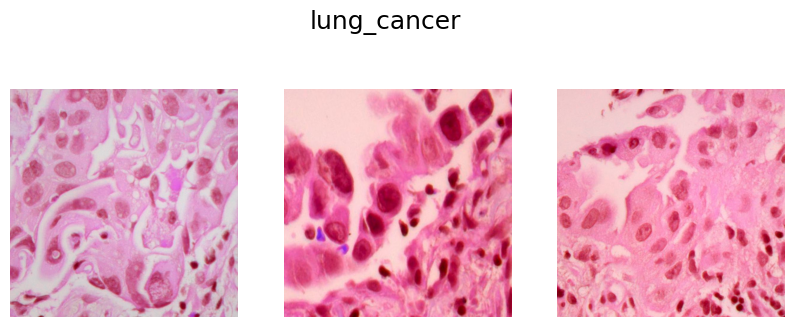

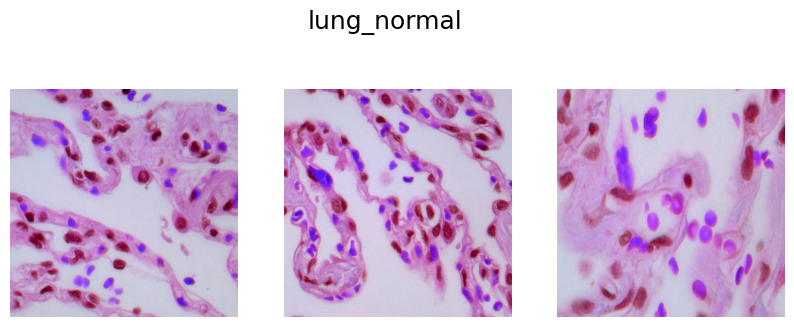

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Displaying the images
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)

    # Initialize a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        # Randomly select an image
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)

        # Display the image
        ax[i].imshow(img_array)
        ax[i].axis('off')

In [9]:

img_array.shape

(768, 768, 3)

In [10]:

IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

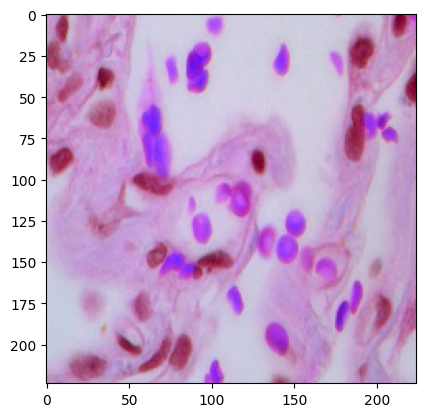

In [11]:
plt.imshow(new_array)

In [12]:
new_array.shape

(224, 224, 3)

In [13]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass

create_training_data()

In [14]:
len(training_data)

10000

In [15]:
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)


In [16]:
type(X),type(y)

(list, list)

In [17]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)    # last value '3' for 'RGB'
y = np.array(y)


In [18]:
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [20]:
print(f'X_train Length : {X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test Length : {X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')


X_train Length : 8000, X_train Image size : (224, 224), Channel Dimension : 3
X_test Length : 2000, X_test Image size : (224, 224), Channel Dimension : 3


In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# freezing the bottom (conv) layers
for layer in vgg.layers:
  layer.trainable = False

In [23]:
# building the top (FC) layers
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'),
])


In [24]:
#compilation
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [27]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.9994 - loss: 0.0027
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 1.0000 - loss: 1.2976e-04
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 1.0000 - loss: 1.3409e-05
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 1.0000 - loss: 2.0757e-06
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 1.0000 - loss: 2.2500e-06


In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.9999 - loss: 4.1392e-04
Model Accuracy : 99.94999766349792


In [29]:
model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step


array([[2.0486592e-12, 1.0000000e+00, 8.6262494e-19],
       [1.0000000e+00, 4.1805139e-17, 3.7855021e-19],
       [1.0000000e+00, 1.2858953e-19, 1.3899752e-20],
       ...,
       [2.2679801e-15, 1.0000000e+00, 9.7478843e-22],
       [1.0000000e+00, 2.4712703e-14, 2.5836199e-16],
       [2.5952247e-25, 1.0000000e+00, 9.7821276e-35]], dtype=float32)

In [30]:
pred = np.argmax(model.predict(X_test), axis = -1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step


In [32]:
pred

array([1, 0, 0, ..., 1, 0, 1])

In [33]:
y_test[:5]

array([1, 0, 0, 0, 0])

In [34]:
pred[:5]

array([1, 0, 0, 0, 0])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

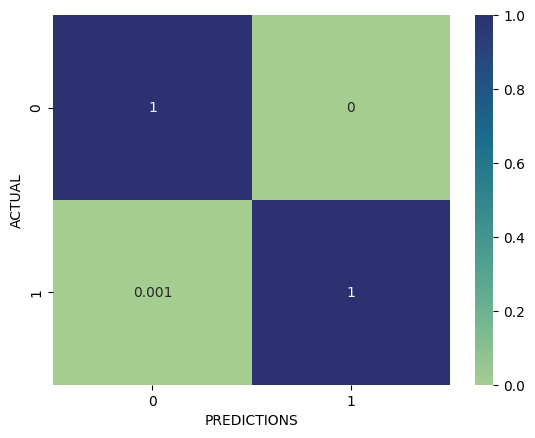

In [36]:

#confusion matrix
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest');
plt.xlabel('PREDICTIONS');
plt.ylabel('ACTUAL');